Business Goal 6: Part 2

In [0]:
#Method: Linear Regression 
#Goal: Explore whether the google trends search score is correlated with the sentiment score

In [0]:
#read in competitor data set (Glossier, Ulta, Sephora and Fenty)
df = spark.read.csv('/FileStore/google_competitors.csv', header='true')
#df.show(5)
#I have an extra column tahts being created so lets delete that 
df2=df.drop('_c0')
df2.show(10)

+----------+------------------+--------+-------+----+-----+--------+
|      Date| average_sentiment|   Brand|Sephora|Ulta|Fenty|Glossier|
+----------+------------------+--------+-------+----+-----+--------+
|2021-01-01|               1.5| Sephora|     88| 100|   70|      35|
|2021-01-01|1.4545454545454546|    Ulta|     88| 100|   70|      35|
|2021-01-01| 1.826086956521739|   Fenty|     88| 100|   70|      35|
|2021-01-01|               1.3|Glossier|     88| 100|   70|      35|
|2021-01-02|               1.7| Sephora|     97|  96|  100|      41|
|2021-01-02|0.7142857142857143|    Ulta|     97|  96|  100|      41|
|2021-01-02|              1.45|   Fenty|     97|  96|  100|      41|
|2021-01-02|               1.6|Glossier|     97|  96|  100|      41|
|2021-01-03|1.3157894736842106|   Fenty|    100|  96|   84|      44|
|2021-01-03|               1.0|    Ulta|    100|  96|   84|      44|
+----------+------------------+--------+-------+----+-----+--------+
only showing top 10 rows



In [0]:
import pyspark.sql.functions as f
#Okay we already know that this data is clean because we created this data set especially for nlp 
#However we are going to do a slight tranfsformation on the data frame so that its easier to use for the linear regression model 
df3= df2.selectExpr("Date","average_sentiment","Brand","stack(4, 'Sephora', Sephora, 'Ulta', Ulta, 'Fenty', Fenty, 'Glossier', Glossier) as (Brand_2,Google_Value)").where("Google_Value is not null")
#df3.show()
#so first lets filter out all the duplicates 
#okay so now we need to filter based on that row 1 for Brand and row 1 for Brand_2 need to be the same and delete the rest 
#the easiest way I can think to do this is split the data frame and then do an inner join 
#we also don't want duplicates so I am removing those
df4_a=df3.drop('Brand_2','Google_Value').distinct().orderBy('Date')
#df4_a.show()
df4_b=df3.drop('average_sentiment','Brand').distinct().orderBy('Date')
#I am going to rename Brand_2 as Brand for this so its easier to join 
df4_c=df4_b.withColumnRenamed("Brand_2","Brand")
#df4_c.show()
#Now do an inner join 
df5=df4_a.join(df4_c,["Date","Brand"]).orderBy("Date")
#df5.show()
#Okay I also don't really need the date and Brand for my regression anymore so I am going to delete them 
df6=df5.drop("Date","Brand")
#Also lets make both of these value numeric so that I dont run into issues for regression 
df7=df6.withColumn("average_sentiment",f.col("average_sentiment").cast("double"))
df8=df7.withColumn("Google_Value",f.col("Google_Value").cast("double"))
df8.show()
#Okay now I can move on to the regression model



+------------------+------------+
| average_sentiment|Google_Value|
+------------------+------------+
|1.4545454545454546|       100.0|
| 1.826086956521739|        70.0|
|               1.5|        88.0|
|               1.3|        35.0|
|              1.45|       100.0|
|               1.6|        41.0|
|               1.7|        97.0|
|0.7142857142857143|        96.0|
|1.3157894736842106|        84.0|
|1.1764705882352942|       100.0|
|               1.0|        96.0|
| 1.380952380952381|        85.0|
|               1.4|        74.0|
|               1.0|        32.0|
|            1.4375|        72.0|
|1.1428571428571428|        84.0|
|1.2857142857142858|        35.0|
|1.2222222222222223|        70.0|
|1.3333333333333333|        58.0|
|            1.3125|        77.0|
+------------------+------------+
only showing top 20 rows



In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

#Step1: Apply transformations 
#source: https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
vectorAssembler = VectorAssembler(inputCols = ['Google_Value'], outputCol = 'features')
#print(vectorAssembler)
v_df8 = vectorAssembler.transform(df8)
v_df8 = v_df8.select(['features', 'average_sentiment'])
#v_df8.show(50)

#Step 2: Split into test and train data set 
#I am going to a standard 80/20 split 
#get count of current number of rows in data set 
#print(df8.count())
#source:https://medium.com/udemy-engineering/pyspark-under-the-hood-randomsplit-and-sample-inconsistencies-examined-7c6ec62644bc
df8_train, df8_test = v_df8.randomSplit(weights = [0.80, 0.20], seed = 1)
#check that this is roughly 80%
#df8_train.count()

#Step 3: Train Linear regression model 
#source: https://anujsyal.com/introduction-to-pyspark-ml-lib-build-your-first-linear-regression-model
lr = LinearRegression(labelCol='average_sentiment')

#Step 4: A Run model on training data 
lrModel = lr.fit(df8_train)

                 
#Step 5: Outputs 
test_stats = lrModel.evaluate(df8_test)
print(f"RMSE: {test_stats.rootMeanSquaredError}")
print(f"R2: {test_stats.r2}")
#Okay so this is very bad 
#Cleary regression is not a very good choice 

RMSE: 0.39016283459150225
R2: 0.03663060276238095


In [0]:
#We are trying to determine if google search trend values are connected in anyway to average_sentiment 
#We got very bad result when trying to run regression and as a result are tryign different models 
#We are going to run a random forest classification model wehre the sentiment_score is assigned rounded to 0(negative),1(neutral),2(positive)
#predicting brand sentiment by using google search trends 
#check what sentimetn score 


In [0]:
#read in competitor data set (Glossier, Ulta, Sephora and Fenty)
df = spark.read.csv('/FileStore/google_competitors.csv', header='true')
#df.show(5)
#I have an extra column tahts being created so lets delete that 
df2=df.drop('_c0')
df2.show(10)

+----------+------------------+--------+-------+----+-----+--------+
|      Date| average_sentiment|   Brand|Sephora|Ulta|Fenty|Glossier|
+----------+------------------+--------+-------+----+-----+--------+
|2021-01-01|               1.5| Sephora|     88| 100|   70|      35|
|2021-01-01|1.4545454545454546|    Ulta|     88| 100|   70|      35|
|2021-01-01| 1.826086956521739|   Fenty|     88| 100|   70|      35|
|2021-01-01|               1.3|Glossier|     88| 100|   70|      35|
|2021-01-02|               1.7| Sephora|     97|  96|  100|      41|
|2021-01-02|0.7142857142857143|    Ulta|     97|  96|  100|      41|
|2021-01-02|              1.45|   Fenty|     97|  96|  100|      41|
|2021-01-02|               1.6|Glossier|     97|  96|  100|      41|
|2021-01-03|1.3157894736842106|   Fenty|    100|  96|   84|      44|
|2021-01-03|               1.0|    Ulta|    100|  96|   84|      44|
+----------+------------------+--------+-------+----+-----+--------+
only showing top 10 rows



In [0]:
import pyspark.sql.functions as f
#Okay we already know that this data is clean because we created this data set especially for nlp 
#However we are going to do a slight tranfsformation on the data frame so that its easier to use for Machine learning 
df3= df2.selectExpr("Date","average_sentiment","Brand","stack(4, 'Sephora', Sephora, 'Ulta', Ulta, 'Fenty', Fenty, 'Glossier', Glossier) as (Brand_2,Google_Value)").where("Google_Value is not null")
#df3.show()
#so first lets filter out all the duplicates 
#okay so now we need to filter based on that row 1 for Brand and row 1 for Brand_2 need to be the same and delete the rest 
#the easiest way I can think to do this is split the data frame and then do an inner join 
#we also don't want duplicates so I am removing those
df4_a=df3.drop('Brand_2','Google_Value').distinct().orderBy('Date')
#df4_a.show()
df4_b=df3.drop('average_sentiment','Brand').distinct().orderBy('Date')
#I am going to rename Brand_2 as Brand for this so its easier to join 
df4_c=df4_b.withColumnRenamed("Brand_2","Brand")
#df4_c.show()
#Now do an inner join 
df5=df4_a.join(df4_c,["Date","Brand"]).orderBy("Date")
df5.show()
#Change data type 
#Make sure to convert average_sentiment to a rounded value since we re doing a random forest classifier 
df6=df5.withColumn("sentiment_category", f.round(df["average_sentiment"]).cast('integer'))
df6.show()
df7=df6.withColumn("Google_Value",f.col("Google_Value").cast("double"))
df7.show()


+----------+--------+------------------+------------+
|      Date|   Brand| average_sentiment|Google_Value|
+----------+--------+------------------+------------+
|2021-01-01|    Ulta|1.4545454545454546|         100|
|2021-01-01|   Fenty| 1.826086956521739|          70|
|2021-01-01| Sephora|               1.5|          88|
|2021-01-01|Glossier|               1.3|          35|
|2021-01-02|   Fenty|              1.45|         100|
|2021-01-02|Glossier|               1.6|          41|
|2021-01-02| Sephora|               1.7|          97|
|2021-01-02|    Ulta|0.7142857142857143|          96|
|2021-01-03|   Fenty|1.3157894736842106|          84|
|2021-01-03| Sephora|1.1764705882352942|         100|
|2021-01-03|    Ulta|               1.0|          96|
|2021-01-04| Sephora| 1.380952380952381|          85|
|2021-01-04|    Ulta|               1.4|          74|
|2021-01-04|Glossier|               1.0|          32|
|2021-01-04|   Fenty|            1.4375|          72|
|2021-01-05| Sephora|1.14285

In [0]:
#Okay so now I am going to break it down by brand 
df7_Sephora=df7.filter(df7.Brand=="Sephora")
df7_Ulta=df7.filter(df7.Brand=="Ulta")
df7_Fenty=df7.filter(df7.Brand=="Fenty")
df7_Glossier=df7.filter(df7.Brand=="Glossier")



In [0]:
#trying random forest 
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix, classification_report

#I am going to build a for loop so that I can run all 4 brands one after the other 
brand_list=[df7_Sephora,df7_Ulta,df7_Fenty,df7_Glossier]
#create empty accuracy score list 
acc_list=[]
#create list to save confusion matrixes 
cm_list=[]
#save the classification report
#I am going to need this for my visulaiztion later 
c_p_list=[]
 
for i in brand_list:

    #Step1: Apply transformations 
    #source: https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    vectorAssembler = VectorAssembler(inputCols = ['Google_Value'], outputCol = 'features')
    #print(vectorAssembler)
    v = vectorAssembler.transform(i)
    v = v.select(['features', 'sentiment_category'])
    #v.show(5)

    #Step 2: Split into test and train data set 
    #I am going to a standard 85/15 split 

    #source:https://medium.com/udemy-engineering/pyspark-under-the-hood-randomsplit-and-sample-inconsistencies-examined-7c6ec62644bc
    train, test = v.randomSplit(weights = [0.8, 0.2], seed = 123)

    #Step 3: Run model 
    #source: https://www.datatechnotes.com/2021/12/mllib-random-forest-classification.html

    rfc = RandomForestClassifier(featuresCol="features", labelCol="sentiment_category")
    rfc = rfc.fit(train)

    pred = rfc.transform(test)
    #pred.show(3) 

    evaluatorRF = MulticlassClassificationEvaluator(labelCol="sentiment_category", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluatorRF.evaluate(pred)


    print("Prediction Accuracy: ", accuracy)
    #print("Prediction Rmse: ", rmse)
    #append to accuracy list
    acc_list.append(accuracy)
    

    y_pred=pred.select("prediction").collect()
    y_orig=pred.select("sentiment_category").collect()

    cm = confusion_matrix(y_orig, y_pred)
    #print("Confusion Matrix:")
    #print(cm)
    cm_list.append(cm)
    #source
    c_p=classification_report(y_orig, y_pred)
    print("classification report",c_p)
    #source:https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
    df_class = pd.DataFrame(classification_report(y_true = y_orig, y_pred = y_pred, output_dict=True)).transpose()
    c_p_list.append(df_class)

Prediction Accuracy:  0.5409836065573771
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/d

In [0]:
#Now print the accuracy list 
print(acc_list)
#the accuracy scores look pretty good 
#To note: Very good model for sephora, not so much for glossier
#print confusion matrices 
print(cm_list)
#print the classification reports 
#these are going to function as my tables for this model ! 
for i in range(len(c_p_list)):
    #print(i)
    #I am printing an empty line for visual purposes 
    print("")
    print("Table"+" "+str(i))
    print(c_p_list[i])
    #save dataframe 
    path="/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/ML/csv/"+str(i)+".csv"
    #print(path)
    c_p_list[i].to_csv(path)
    

[0.5409836065573771, 0.5081967213114754, 0.8114754098360656, 0.7704918032786885]
[array([[ 0,  2,  0],
       [ 0, 61,  8],
       [ 0, 46,  5]]), array([[ 0,  3,  1],
       [ 0, 49, 13],
       [ 0, 43, 13]]), array([[ 0, 23],
       [ 0, 99]]), array([[ 0,  0,  1],
       [ 0,  0, 26],
       [ 0,  1, 94]])]

Table 0
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000    2.000000
1              0.559633  0.884058  0.685393   69.000000
2              0.384615  0.098039  0.156250   51.000000
accuracy       0.540984  0.540984  0.540984    0.540984
macro avg      0.314749  0.327366  0.280548  122.000000
weighted avg   0.477296  0.540984  0.452958  122.000000

Table 1
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000    4.000000
1              0.515789  0.790323  0.624204   62.000000
2              0.481481  0.232143  0.313253   56.000000
accuracy       0.508197  0.508197  0.508197    0.5081

In [0]:
import pandas as pd
#Now I am going to make a table and visualizations
#Table: 
#Create a dataframe 

data = {'Brands': ["Sephora","Ulta","Fenty","Glossier"],
        'Accuracy': acc_list}
df_accuracy = pd.DataFrame(data, columns=['Brands', 'Accuracy'])
print(df_accuracy)
#save to csv
df_accuracy.to_csv("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/ML/df_accuracy_competitors_random_forest.csv")



     Brands  Accuracy
0   Sephora  0.540984
1      Ulta  0.508197
2     Fenty  0.811475
3  Glossier  0.770492


In [0]:
#Now I am going to make a visualization based on the confusion matrixes I have 


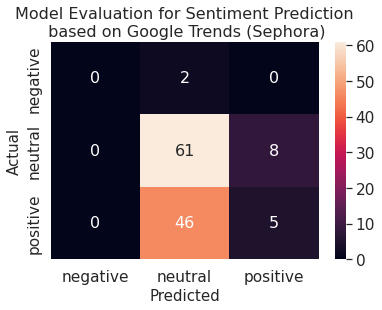

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os 
## Plot confusion matrices 
df_cm_Sephora=cm_list[0]
df_cm_Ulta=cm_list[1]
df_cm_Fenty=cm_list[2]
df_cm_Glossier=cm_list[3]

sns.set(font_scale=1.4)
x_axis_labels = ["negative","neutral","positive"] # labels for x-axis
y_axis_labels = ["negative","neutral","positive"]
new=sns.heatmap(df_cm_Sephora,  xticklabels=x_axis_labels,yticklabels=y_axis_labels, annot=True, annot_kws={"size": 16})
plt.title('Model Evaluation for Sentiment Prediction\n based on Google Trends (Sephora)', fontsize=16)
plt.xlabel('Predicted', fontsize = 15) 
plt.ylabel('Actual', fontsize = 15) 
plot_fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/ML/", 'Sephora_cm.png')
plt.savefig(plot_fpath)

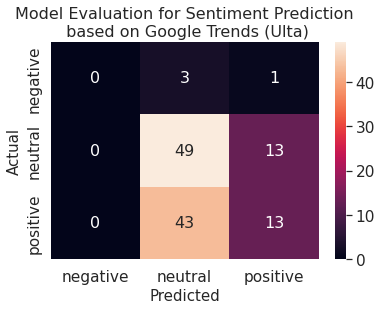

In [0]:
#confusion matrix 2 
x_axis_labels = ["negative","neutral","positive"] # labels for x-axis
y_axis_labels = ["negative","neutral","positive"]
sns.heatmap(df_cm_Ulta,  xticklabels=x_axis_labels,yticklabels=y_axis_labels, annot=True, annot_kws={"size": 16})
plt.title('Model Evaluation for Sentiment Prediction\n based on Google Trends (Ulta)', fontsize=16)
plt.xlabel('Predicted', fontsize = 15) 
plt.ylabel('Actual', fontsize = 15) 
plot_fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/ML/", 'Ulta_cm.png')
plt.savefig(plot_fpath)

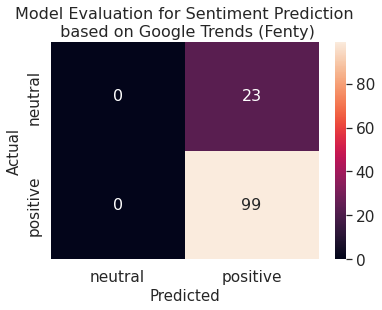

In [0]:
x_axis_labels = ["neutral","positive"] # labels for x-axis
y_axis_labels = ["neutral","positive"]
sns.heatmap(df_cm_Fenty,  xticklabels=x_axis_labels,yticklabels=y_axis_labels, annot=True, annot_kws={"size": 16})
plt.title('Model Evaluation for Sentiment Prediction\n based on Google Trends (Fenty)', fontsize=16)
plt.xlabel('Predicted', fontsize = 15) 
plt.ylabel('Actual', fontsize = 15) 
plot_fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/ML/", 'Fenty_cm.png')
plt.savefig(plot_fpath)

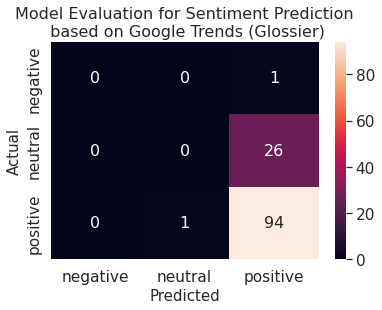

In [0]:
x_axis_labels = ["negative","neutral","positive"] # labels for x-axis
y_axis_labels = ["negative","neutral","positive"]
sns.heatmap(df_cm_Glossier,  xticklabels=x_axis_labels,yticklabels=y_axis_labels, annot=True, annot_kws={"size": 16})
plt.title('Model Evaluation for Sentiment Prediction\n based on Google Trends (Glossier)', fontsize=16)
plt.xlabel('Predicted', fontsize = 15) 
plt.ylabel('Actual', fontsize = 15) 
plot_fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/ML/", 'Glossier_cm.png')
plt.savefig(plot_fpath)